<center><h1 style="font-size:35px; font-family: 'Times New Roman'; letter-spacing: 0.1em;">Clustering</h1></center>

## Introduction
To build our recommendation engine, the first crucial step is to group users into clusters. This process begins by merging all relevant data into a comprehensive dataset (`all_orders`). 

Next, we generate features representing aisle preferences before applying **Principal Component Analysis (PCA)** to reduce the dimensionality of the dataset (the number of product features). This step improves performance by simplifying the data while preserving essential information.

Finally, we apply **K-Means clustering** to identify the optimal number of user segments and assign each user to their respective cluster based on their aisle preferences, forming the foundation for personalized recommendations.

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import pyarrow as pa
import pyarrow.parquet as pq
from zipfile import ZipFile

In [2]:
products = pd.read_csv('Data/products.csv')
aisles = pd.read_csv('Data/aisles.csv')
departments = pd.read_csv('Data/departments.csv')
order_products_prior = pd.read_csv('Data/order_products__prior.csv')
order_products_train = pd.read_csv('Data/order_products__train.csv')
orders = pd.read_csv('Data/orders.csv')

all_orders = pd.concat([order_products_prior,order_products_train])
all_orders = all_orders.merge(orders[['order_id','user_id']], on='order_id', how='inner')
all_orders = all_orders.merge(products, on = 'product_id', how='inner')
all_orders = all_orders.merge(departments, on = 'department_id', how='inner')
all_orders = all_orders.merge(aisles, on = 'aisle_id', how='inner')
all_orders.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs
1,2,28985,2,1,202279,Michigan Organic Kale,83,4,produce,fresh vegetables
2,2,9327,3,0,202279,Garlic Powder,104,13,pantry,spices seasonings
3,2,45918,4,1,202279,Coconut Butter,19,13,pantry,oils vinegars
4,2,30035,5,0,202279,Natural Sweetener,17,13,pantry,baking ingredients


<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;"> Feature Engineering "Aisle Share"</h1>

Before running our kmeans clustering algorithm, we wanted to develop a feature that would capture the relationship between the products purchased and aisles per user. We did this by counting the total number of products by aisle over total products purchased. we want to determine how much of a user's total purchases come from each aisle. This feature, called "aisle share", will represent the proportion of a user’s total product purchases that come from a specific aisle. It will be used later as input for clustering to group users based on their purchasing habits.

note : there are other features too can help you to clustering users based on user level like :
```python  
1-Average basket size
avg_basket_size = all_orders.groupby(['user_id', 'order_id'])['product_id'].count().reset_index()
avg_basket_size = avg_basket_size.groupby('user_id')['product_id'].mean().reset_index()
avg_basket_size.columns = ['user_id', 'avg_basket_size']

2- order_frequency:
order_frequency = all_orders[all_orders['order_number'] > 1].groupby('user_id')['days_since_prior_order'].mean().reset_index()
order_frequency.columns = ['user_id', 'avg_days_between_orders']

3-Preferred order time:
preferred_order_time = all_orders.groupby('user_id').agg({
    'order_dow': lambda x: x.value_counts().index[0],
    'order_hour_of_day': lambda x: x.value_counts().index[0]}).reset_index()
preferred_order_time.columns = ['user_id', 'preferred_dow', 'preferred_hour']

In [4]:
#we want to count how many products each user bought from each aisle:
cnt_per_aisle = all_orders[['user_id','aisle','product_name']].groupby(['user_id', 'aisle']).count().reset_index() 
cnt_per_aisle = cnt_per_aisle.rename(columns={'product_name':'product_cnt_per_aisle'})
cnt_per_aisle

,user_id,aisle,product_cnt_per_aisle
0,1,candy chocolate,2
1,1,cereal,4
2,1,cream,3
3,1,fresh fruits,5
4,1,milk,1
...,...,...,...
5919835,206209,soft drinks,11
5919836,206209,soy lactosefree,10
5919837,206209,spices seasonings,1
5919838,206209,trash bags liners,1


In [5]:
#calculate the total number of products bought by each user across all aisles
ttl_per_user = cnt_per_aisle.groupby(["user_id"]).sum()
ttl_per_user

,aisle,product_cnt_per_aisle
user_id,,
1,candy chocolatecerealcreamfresh fruitsmilknuts...,70
2,asian foodsbaking ingredientsbreadbreakfast ba...,226
3,crackersfresh fruitsfresh vegetablesfrozen bre...,88
4,breadchips pretzelsdish detergentsfresh dips t...,18
5,air fresheners candlesasian foodscanned jarred...,46
...,...,...
206205,baby accessoriesbreadcondimentscreamfresh dips...,51
206206,asian foodsbaking ingredientsbaking supplies d...,285
206207,baby food formulabreadcanned jarred vegetables...,223


We ensure that for each user, we know how many products they bought from each aisle `(cnt_per_aisle)` and the total number of products they bought across all aisles `(ttl_per_user)`.

In [6]:
# Calculate total product count per aisle
cnt_per_aisle = all_orders.groupby(['user_id', 'aisle']).size().reset_index(name='product_cnt_per_aisle')

# Calculate total product count per user
ttl_per_user = cnt_per_aisle.groupby('user_id')['product_cnt_per_aisle'].sum().reset_index(name='ttl_product_cnt_per_user')

In [7]:
# We merge the aisle-wise product counts (cnt_per_aisle) with the total product counts for each user (ttl_per_user)
aisle_share_per_user = cnt_per_aisle.merge(ttl_per_user, how="left", on="user_id")

# We calculate the aisle share, which is the proportion of the user's purchases that come from a particular aisle
aisle_share_per_user["aisle_share"] = aisle_share_per_user["product_cnt_per_aisle"] / aisle_share_per_user["ttl_product_cnt_per_user"]

# Drop unnecessary columns
aisle_share_per_user.drop(["product_cnt_per_aisle", "ttl_product_cnt_per_user"], axis=1, inplace=True)

# Check the resulting DataFrame
aisle_share_per_user

,user_id,aisle,aisle_share
0,1,candy chocolate,0.028571
1,1,cereal,0.057143
2,1,cream,0.042857
3,1,fresh fruits,0.071429
4,1,milk,0.014286
...,...,...,...
5919835,206209,soft drinks,0.080292
5919836,206209,soy lactosefree,0.072993
5919837,206209,spices seasonings,0.007299
5919838,206209,trash bags liners,0.007299


This new feature, `aisle share`, summarizes each user’s preference for certain aisles relative to their total shopping behavior. It helps in clustering users based on their aisle preferences, which is a key step in building personalized recommendation systems. By grouping users who have similar shopping patterns, the system can better understand user behaviors and make more accurate recommendations.

Summary:

"Aisle Share": This new feature represents the proportion of a user's total purchases that come from a specific aisle. It gives insight into each user's preference for different aisles.so it helps us understand users' shopping patterns and will be used to cluster users based on their aisle preferences.

Usage in Clustering: Once we have the aisle share for each user, we can use it as one of the key inputs to group users with similar shopping habits (for example, users who mostly buy products from the same aisles).

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;"> Preparing our dataset for dimensionality reduction</h1>

Before performing our principal component analysis we need to adjust our dataframe using pivot to transform our aisle per share into columns (features). 

We pivot the `aisle_share_per_user` DataFrame to transform the data into a format where each column corresponds to an aisle, and each row corresponds to a user.
Explanation:
The `pivot()` function rearranges the data such that the aisles become the columns, the users become the rows (index), and the values in the table are the `aisle_share` (proportion of purchases from that aisle).
Now, each row represents a user and contains their `aisle share` for every aisle they bought products from.

In [8]:
#Setting aisles as columns by user id using pivot. 
aisle_share_pivot = aisle_share_per_user.pivot(index="user_id", columns="aisle", values="aisle_share")
aisle_share_pivot

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.014286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028571
2,NaN,0.013274,NaN,NaN,NaN,NaN,0.008850,NaN,NaN,NaN,...,0.013274,0.004425,0.004425,NaN,NaN,NaN,NaN,0.008850,NaN,0.185841
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.045455,0.011364,NaN,NaN,NaN,NaN,NaN,0.022727,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.055556,NaN,NaN,NaN,0.055556,NaN,NaN
5,0.021739,0.086957,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.065217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206205,NaN,NaN,0.019608,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.176471
206206,NaN,0.014035,NaN,NaN,NaN,NaN,0.014035,0.003509,NaN,NaN,...,0.003509,NaN,NaN,NaN,NaN,0.003509,NaN,0.003509,NaN,NaN
206207,NaN,NaN,NaN,NaN,0.004484,NaN,NaN,NaN,NaN,NaN,...,0.013453,0.017937,NaN,0.008969,0.004484,NaN,NaN,0.049327,NaN,0.067265



Finally have a **user-aisle matrix** where each user’s behavior (`aisle share`) is now captured in a single row. This will make it easier to perform dimensionality reduction using PCA.


<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Dimensionality reduction using PCA </h1>

The goal is to reduce the complexity of the dataset and size (with 134 columns/features) while maintaining as much of the variance in the data as possible and alsocan help filter out irrelevant features and noise that may not contribute to distinguishing between user behaviors

<h3 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;"> Finding the optimal number of dimensions</h1>

In [9]:
pca = PCA()
# principal components and projects the data into the new space of reduced dimensions.
pca.fit_transform(aisle_share_pivot.fillna(0))
# How much variance each principal component explains
# cumsum() Func computes cumulative sum of explained variance, helping us identify how many components (dimensions) are needed to reach our threshold of 80% explained variance
cumsum = np.cumsum(pca.explained_variance_ratio_)
threshold = 0.80 
# Helps us find the number of components (dimensions) needed to reach that threshold. The +1 ensures that the index is correctly adjusted
d = np.argmax(cumsum >= threshold) + 1

we need to decide how many principal components to keep. To do this so We plot the elbow curve to visually inspect how the explained variance changes with the number of components. This curve helps us understand the relationship between the number of principal components (dimensions) and the cumulative explained variance.

Threshold: A typical approach is to retain components that together explain 80% of the variance in the data. This ensures that most of the important information is preserved while reducing dimensionality.

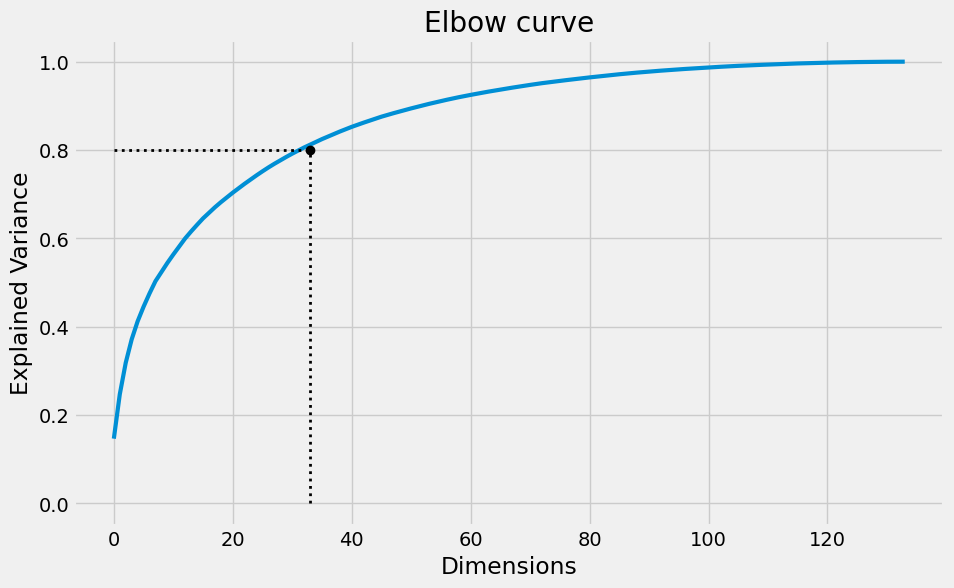

In [10]:
#graphically displaying the optimal components 
plt.style.use("fivethirtyeight")
plt.figure(figsize=(10,6))
plt.plot(cumsum, linewidth=3)
plt.title("Elbow curve")
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, threshold], "k:", linewidth=2)
plt.plot([0, d], [threshold, threshold], "k:",linewidth=2)
plt.plot(d, threshold, "ko")
plt.grid(True)
plt.show()

In [11]:
d

33

By applying PCA and reducing the number of dimensions from 134 to 33, we significantly reduce the complexity of the dataset. This helps:

Improve the performance of downstream algorithms, such as k-means clustering.
Remove noise or less important features while preserving the key variance in the dataset.
Make the data more manageable and interpretable, allowing us to focus on the most meaningful patterns for clustering and recommendation tasks.

Using the elbow curve and a threshold of 80% explained variance, we find the optimal nubmer of dimensions to be 33. We will now create a seperate 

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Reducing our dataframe using 33 components </h1>

In [12]:
#creating a dataframe with d number of components. 
pca = PCA(n_components=d)
prinicpalComponents = pca.fit_transform(aisle_share_pivot.fillna(0))
PCA_components = pd.DataFrame(prinicpalComponents)
PCA_components

,0,1,2,3,4,5,6,7,8,9,...,23,24,25,26,27,28,29,30,31,32
0,-0.122382,0.028613,-0.047848,0.012765,-0.075252,-0.111792,-0.100821,0.088240,-0.063939,-0.002240,...,0.000588,0.078412,0.026772,0.100216,0.029464,-0.030695,0.012426,0.001216,0.000254,-0.013192
1,-0.034421,0.111616,-0.064131,-0.109469,0.073280,-0.029577,-0.049185,-0.058598,-0.010469,-0.018545,...,0.038826,0.007530,-0.003276,-0.003513,-0.002055,0.001415,0.004845,-0.025313,-0.000878,0.025641
2,0.063256,0.104112,0.000496,-0.014156,-0.047741,0.111111,-0.031840,0.013007,0.011865,0.004862,...,0.058671,-0.005009,0.000022,0.015171,-0.005993,-0.004139,-0.002623,0.005528,-0.024142,-0.007498
3,-0.094301,0.052756,0.001039,-0.005062,-0.071580,-0.017770,-0.025076,-0.038995,0.009993,-0.014020,...,0.008485,0.005175,-0.000415,0.004367,-0.017738,0.010735,-0.017212,-0.061552,0.066856,-0.001100
4,0.089432,-0.031068,-0.022805,-0.011826,0.042319,0.111466,-0.015765,0.100999,0.025115,-0.036498,...,-0.005745,0.009423,0.002083,-0.005288,-0.000031,0.000999,-0.002648,0.004386,-0.012126,-0.002096
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,0.001716,0.084855,-0.065398,-0.068637,0.114988,-0.028519,0.020656,0.023947,-0.027584,-0.016769,...,-0.003527,-0.026574,-0.005975,0.027308,-0.001569,-0.003968,0.014031,-0.023404,0.014776,0.033517
206205,-0.089658,-0.046734,-0.048290,0.012789,-0.059580,-0.000541,-0.013954,-0.042901,0.143139,-0.060012,...,0.002413,0.042991,-0.008989,0.027623,0.031968,-0.032637,-0.002283,-0.012577,-0.011490,-0.013819
206206,-0.024827,-0.013519,-0.003968,-0.030921,0.032991,0.020682,0.037647,0.032884,-0.022779,-0.002579,...,0.006681,-0.002433,0.012653,-0.010403,0.005650,-0.003780,0.005073,-0.004771,-0.007575,-0.001160
206207,-0.009310,-0.003375,-0.045594,-0.012231,0.013764,0.055681,0.008131,0.029494,-0.010690,0.020782,...,-0.011727,-0.001546,-0.007065,0.013288,-0.000622,-0.004278,-0.004640,-0.002386,-0.016024,0.006177


<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Segmenting our users using K-Means</h1>

<h2 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Find optimal number of clusters using elbow method </h2>
Using 3 different methods we evaluate the optimal number of clusters to use for our segmentation. 

In [13]:
#finding optimal number of clusters. 
sse = {}
labels = {}
for k in range(5,30):
    print(k)
    kmeans = KMeans(n_clusters = k).fit(PCA_components[range(d)])
    sse[k] = kmeans.inertia_
    labels[k] = kmeans.labels_

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


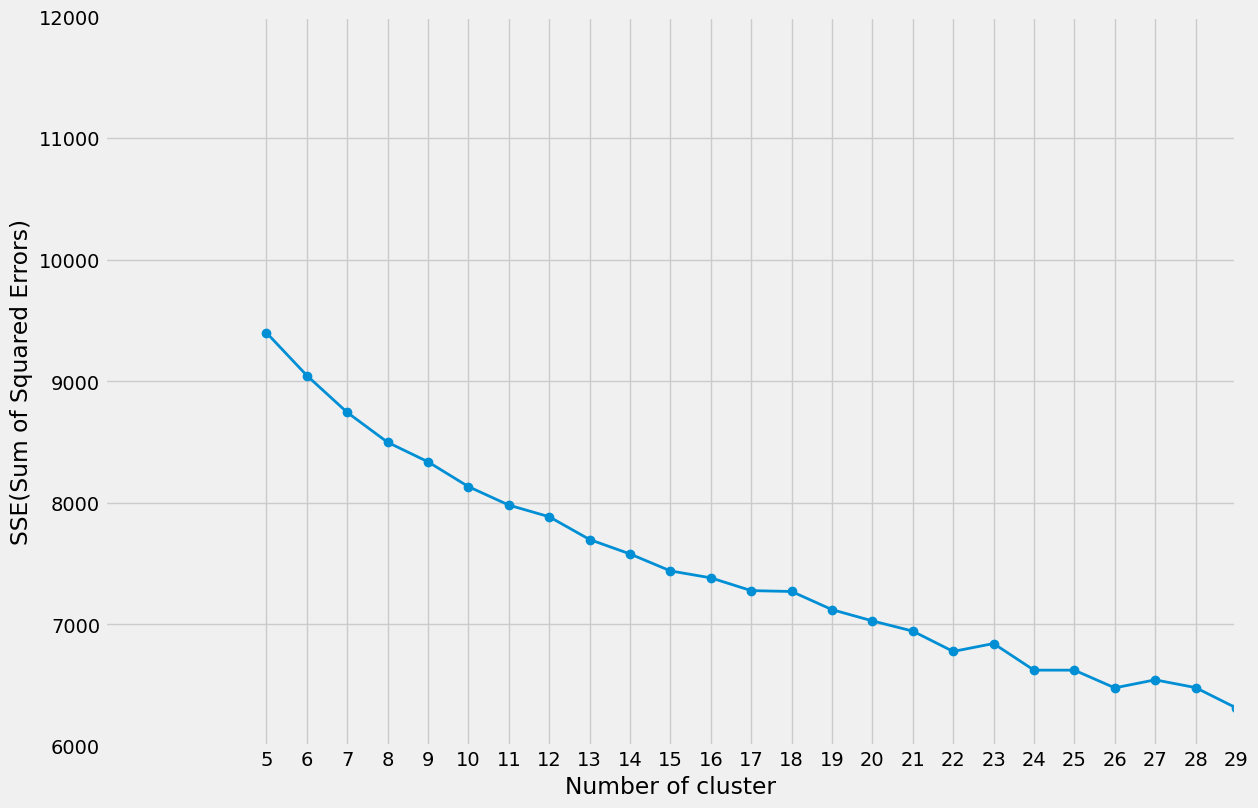

In [49]:
plt.figure(figsize=(13,9))
plt.plot(list(sse.keys()), list(sse.values()), "-o", linewidth=2)
plt.xlabel("Number of cluster")
plt.ylabel("SSE(Sum of Squared Errors)")
plt.ylim(6000, 12000)
plt.xlim(1,20)
plt.xticks(range(5,30))
plt.show()

Using the elbow method in this case is hard as there is no significant change in slope. so we can find the place in which the slow down in pct %-change is the greatest.


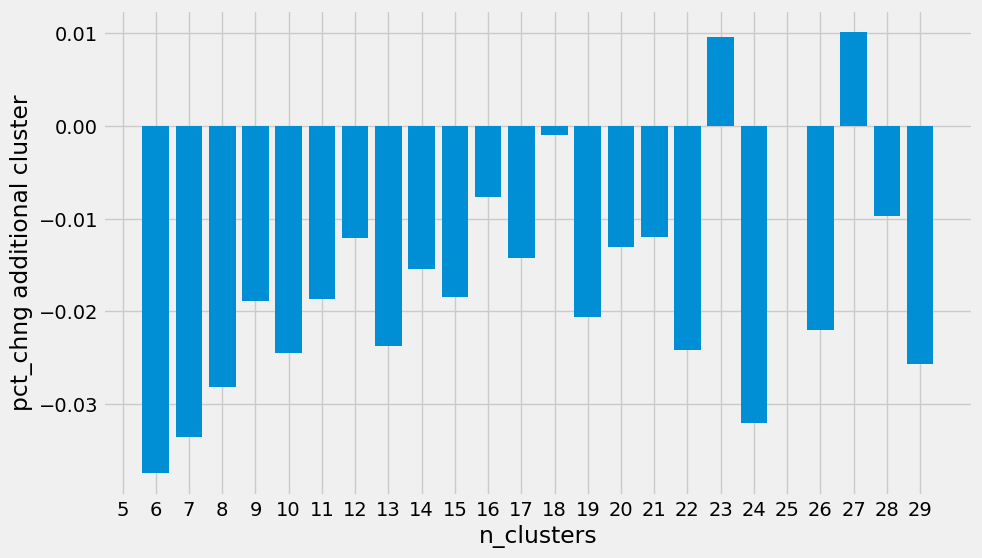

In [16]:
pct_change_clusters = pd.Series(sse.values()).pct_change()
plt.figure(figsize=(10,6))
plt.bar(sse.keys(), pct_change_clusters)
plt.xlabel("n_clusters")
plt.ylabel("pct_chng additional cluster")
plt.xticks(np.arange(5,30))
plt.show()

Looking at the bar chart graph we can see, that around 4 and 5 the pct changes kind of start balancing out. As such we decided to go for a cluster number of 5

In [17]:
# Setting k to 18
k = 18

In [18]:
# Filling the NaN with 0
aisle_share_pivot = aisle_share_pivot.fillna(0)

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Preparing our dataframe for collaborative filtering </h1>


Now that we have segmented the users into clusters, we prepare the dataset for use in the collaborative filtering process, which will be covered in the next section. The goal is to shape a final DataFrame consisting of `order_id`, `product_id`, `cluster`, and `user_id`.

<h2 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Segmenting our users using K-Means</h2>

In [19]:
#concatting cluster onto 
cluster_df = pd.concat([PCA_components[range(d)], pd.Series(labels[k]).rename('cluster')], axis = 1)
cluster_df = pd.concat([pd.Series(aisle_share_pivot.index),cluster_df],axis = 1)
cluster_df

,user_id,0,1,2,3,4,5,6,7,8,...,24,25,26,27,28,29,30,31,32,cluster
0,1,-0.122382,0.028613,-0.047848,0.012765,-0.075252,-0.111792,-0.100821,0.088240,-0.063939,...,0.078412,0.026772,0.100216,0.029464,-0.030695,0.012426,0.001216,0.000254,-0.013192,17
1,2,-0.034421,0.111616,-0.064131,-0.109469,0.073280,-0.029577,-0.049185,-0.058598,-0.010469,...,0.007530,-0.003276,-0.003513,-0.002055,0.001415,0.004845,-0.025313,-0.000878,0.025641,5
2,3,0.063256,0.104112,0.000496,-0.014156,-0.047741,0.111111,-0.031840,0.013007,0.011865,...,-0.005009,0.000022,0.015171,-0.005993,-0.004139,-0.002623,0.005528,-0.024142,-0.007498,6
3,4,-0.094301,0.052756,0.001039,-0.005062,-0.071580,-0.017770,-0.025076,-0.038995,0.009993,...,0.005175,-0.000415,0.004367,-0.017738,0.010735,-0.017212,-0.061552,0.066856,-0.001100,10
4,5,0.089432,-0.031068,-0.022805,-0.011826,0.042319,0.111466,-0.015765,0.100999,0.025115,...,0.009423,0.002083,-0.005288,-0.000031,0.000999,-0.002648,0.004386,-0.012126,-0.002096,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,206205,0.001716,0.084855,-0.065398,-0.068637,0.114988,-0.028519,0.020656,0.023947,-0.027584,...,-0.026574,-0.005975,0.027308,-0.001569,-0.003968,0.014031,-0.023404,0.014776,0.033517,5
206205,206206,-0.089658,-0.046734,-0.048290,0.012789,-0.059580,-0.000541,-0.013954,-0.042901,0.143139,...,0.042991,-0.008989,0.027623,0.031968,-0.032637,-0.002283,-0.012577,-0.011490,-0.013819,0
206206,206207,-0.024827,-0.013519,-0.003968,-0.030921,0.032991,0.020682,0.037647,0.032884,-0.022779,...,-0.002433,0.012653,-0.010403,0.005650,-0.003780,0.005073,-0.004771,-0.007575,-0.001160,2
206207,206208,-0.009310,-0.003375,-0.045594,-0.012231,0.013764,0.055681,0.008131,0.029494,-0.010690,...,-0.001546,-0.007065,0.013288,-0.000622,-0.004278,-0.004640,-0.002386,-0.016024,0.006177,2


In [20]:
#Adding cluster number to our asile share per user dataframe 
cluster_aisle_br = aisle_share_per_user.merge(cluster_df[['user_id','cluster']], on = 'user_id')
cluster_aisle_br

,user_id,aisle,aisle_share,cluster
0,1,candy chocolate,0.028571,17
1,1,cereal,0.057143,17
2,1,cream,0.042857,17
3,1,fresh fruits,0.071429,17
4,1,milk,0.014286,17
...,...,...,...,...
5919835,206209,soft drinks,0.080292,2
5919836,206209,soy lactosefree,0.072993,2
5919837,206209,spices seasonings,0.007299,2
5919838,206209,trash bags liners,0.007299,2


In [21]:
all_orders_cluster = all_orders.merge(cluster_df[['user_id','cluster']], on = 'user_id')
all_orders_cluster

,order_id,product_id,add_to_cart_order,reordered,user_id,product_name,aisle_id,department_id,department,aisle,cluster
0,2,33120,1,1,202279,Organic Egg Whites,86,16,dairy eggs,eggs,3
1,2,28985,2,1,202279,Michigan Organic Kale,83,4,produce,fresh vegetables,3
2,2,9327,3,0,202279,Garlic Powder,104,13,pantry,spices seasonings,3
3,2,45918,4,1,202279,Coconut Butter,19,13,pantry,oils vinegars,3
4,2,30035,5,0,202279,Natural Sweetener,17,13,pantry,baking ingredients,3
...,...,...,...,...,...,...,...,...,...,...,...
33819101,3421063,14233,3,1,169679,Natural Artesian Water,115,7,beverages,water seltzer sparkling water,13
33819102,3421063,35548,4,1,169679,Twice Baked Potatoes,13,20,deli,prepared meals,13
33819103,3421070,35951,1,1,139822,Organic Unsweetened Almond Milk,91,16,dairy eggs,soy lactosefree,17
33819104,3421070,16953,2,1,139822,Creamy Peanut Butter,88,13,pantry,spreads,17


By segmenting users into clusters using K-Means and preparing the data, we now have a structured dataset ready for use in building a recommendation system that can leverage both user behavior and cluster membership. The collaborative filtering approach will allow us to recommend products to users based on their cluster and purchase history.

## 2.7 Exploring the clusters

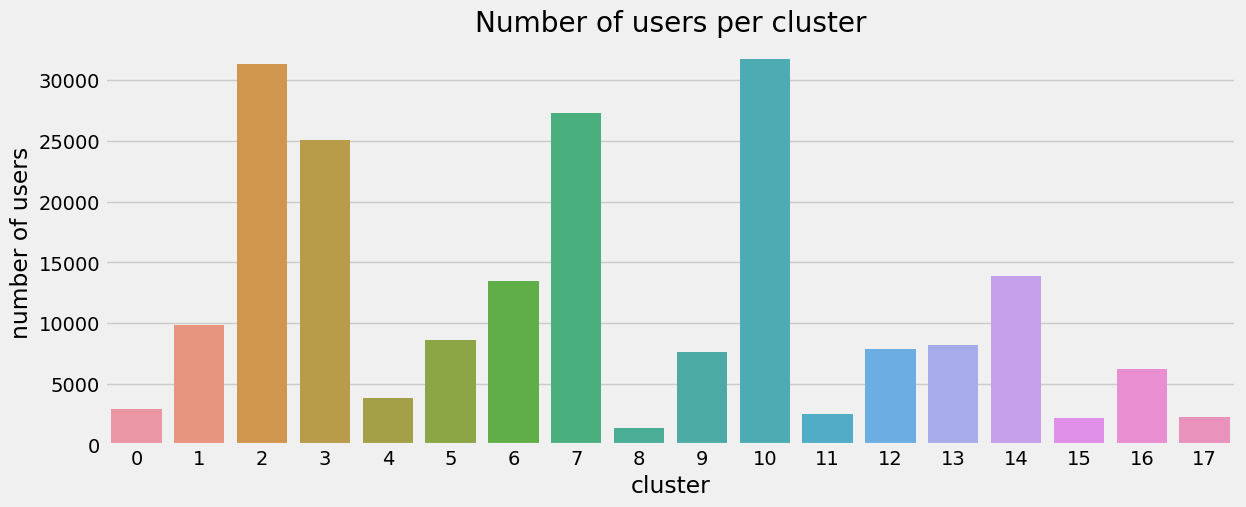

In [26]:
# checking the number of users per cluster
user_per_cluster = all_orders_cluster.groupby("cluster").nunique()["user_id"]
plt.figure(figsize=(13, 5))
sns.barplot(x=user_per_cluster.index, y=user_per_cluster.values)
plt.title("Number of users per cluster")
plt.xlabel("cluster")
plt.ylabel("number of users")
plt.show()

Looking at the above graph we can see, that `cluster 2`, `cluster 10` and `cluster 3` have the most users, where as `cluster 8` and `cluster 11` have the least. Although users is an inidcator, let's see how it looks in terms of number of orders

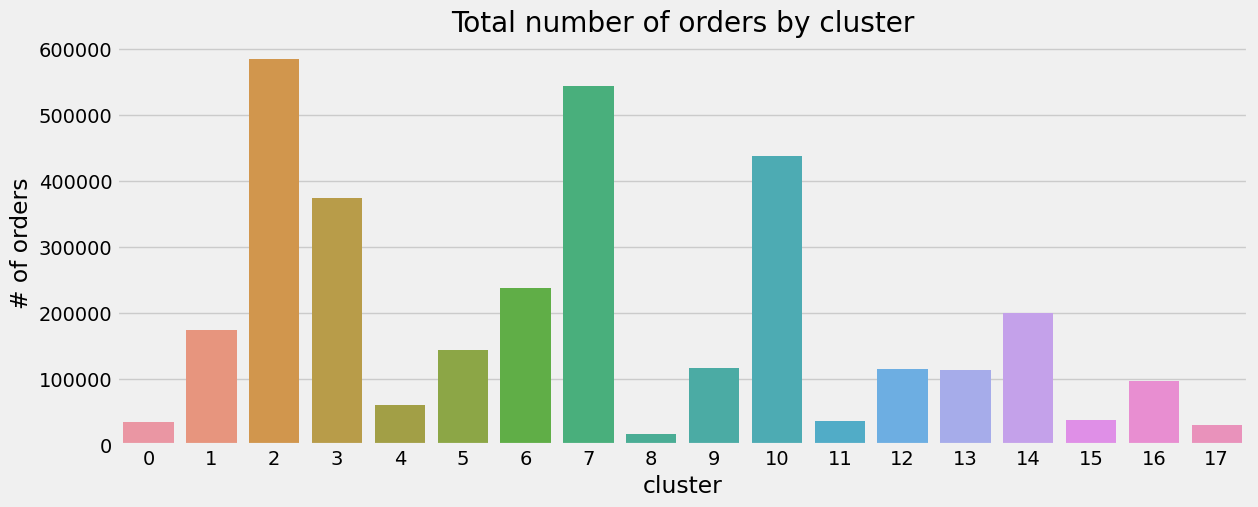

In [27]:
# Calculating the number of users per cluster
orders_per_cluster=all_orders_cluster.groupby("cluster")["order_id"].nunique()
plt.figure(figsize=(13,5))
sns.barplot(x=orders_per_cluster.index, y=orders_per_cluster.values)
plt.title("Total number of orders by cluster")
plt.ylabel("# of orders")
plt.show()

As expected, the distribution of the total number of orders per cluster looks similar as the total number of users per clusters as more useres usually also means more orders. Let's explore the ratios...

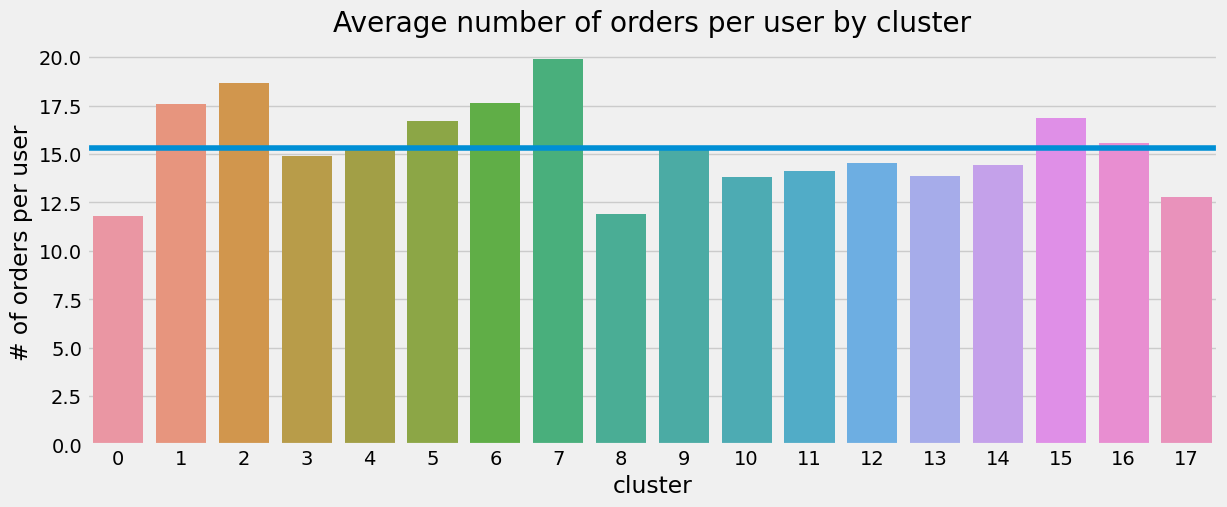

In [28]:
plt.figure(figsize=(13,5))
sns.barplot(x=orders_per_cluster.index, y=orders_per_cluster.values/user_per_cluster.values).axhline(np.mean(orders_per_cluster.values/user_per_cluster.values))
plt.title("Average number of orders per user by cluster")
plt.ylabel("# of orders per user")
plt.show()

When we look at the average number of orders per user we have a a bit a more even distribution. `cluster 1` , `cluster 2` , `cluster 7` and `cluster 15` users tend to order the most, where as `cluster 0` & `cluster 8` users have the loweser average number of orders.

Next, let's check if there is a significant difference in the average number of products bought per order...

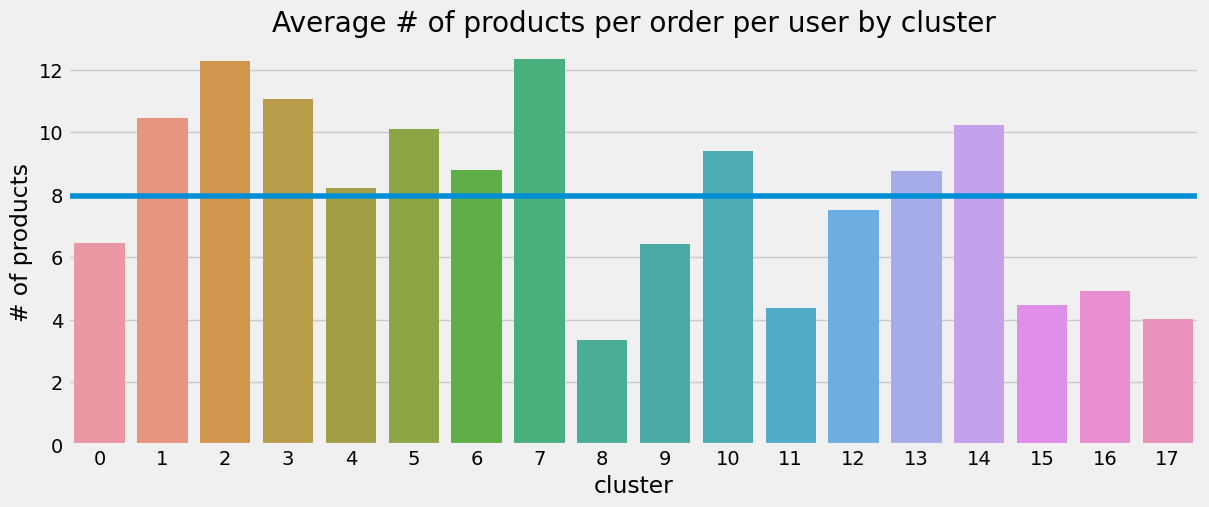

In [29]:
avg_num_prod_per_order_by_cluster = all_orders_cluster.groupby(["cluster","order_id"]).count()["product_id"].groupby("cluster").mean()
plt.figure(figsize=(13,5))
sns.barplot(x=avg_num_prod_per_order_by_cluster.index, y=avg_num_prod_per_order_by_cluster.values).axhline(np.mean(avg_num_prod_per_order_by_cluster))
plt.title("Average # of products per order per user by cluster")
plt.ylabel("# of products")
plt.show()

Looking at the bar chart we can clearly see a difference between the different clusters. The average number of products per order for `cluster 8`and `cluster 11` is stark below the average of 8, where as for `cluster 1`, `cluster 2` , `cluster 3` and `cluster 7` it is clearly above.

Now let's see if we can find some patterns in the different clusters

In [30]:
orders_per_cluster.values

array([ 34219, 173451, 584777, 373583,  59335, 143221, 237020, 543696,
        16451, 115389, 438126,  35475, 114618, 113794, 200216,  37231,
        96412,  29069], dtype=int64)

In [31]:
# Count the number of times each product is bought within each cluster
top_products_by_cluster = (
    all_orders_cluster.groupby(['cluster', 'product_name'])['product_id']
    .count()
    .reset_index()  # Reset index so we can easily sort
    .sort_values(['cluster', 'product_id'], ascending=[True, False])) # Sort by cluster and product count

# Group by 'cluster' and get the top 5 products in each cluster
top_products_by_cluster = top_products_by_cluster.groupby('cluster').head(5)
top_products_by_cluster

,cluster,product_name,product_id
1404,0,Banana,1746
3417,0,Chocolate Ice Cream,1698
1309,0,Bag of Organic Bananas,1074
19678,0,Vanilla Bean Light Ice Cream,1040
18043,0,Strawberry Ice Cream,1004
...,...,...,...
434624,17,Soda,9648
436268,17,Zero Calorie Cola,3278
429432,17,Fridge Pack Cola,1411
428700,17,Diet,1108


<Figure size 1500x800 with 0 Axes>

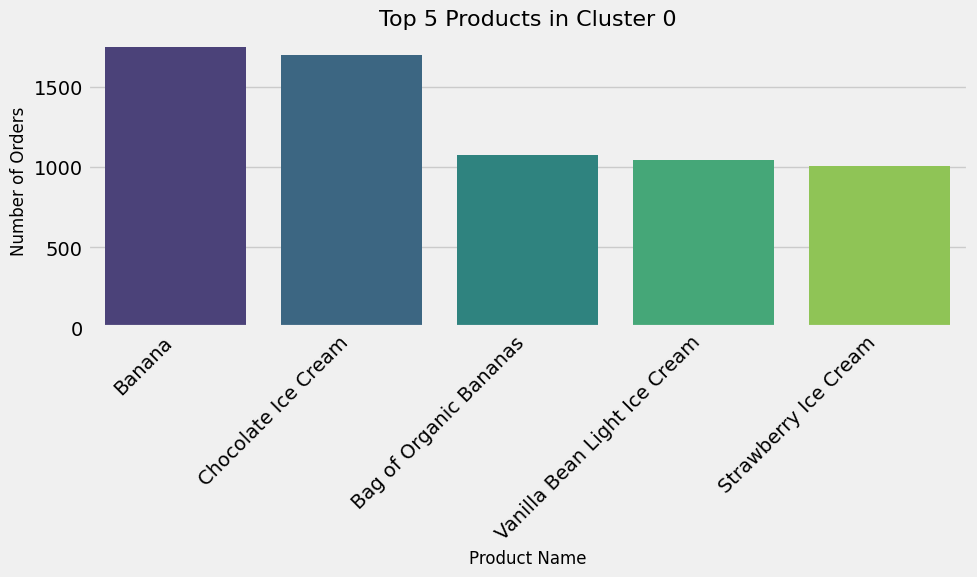

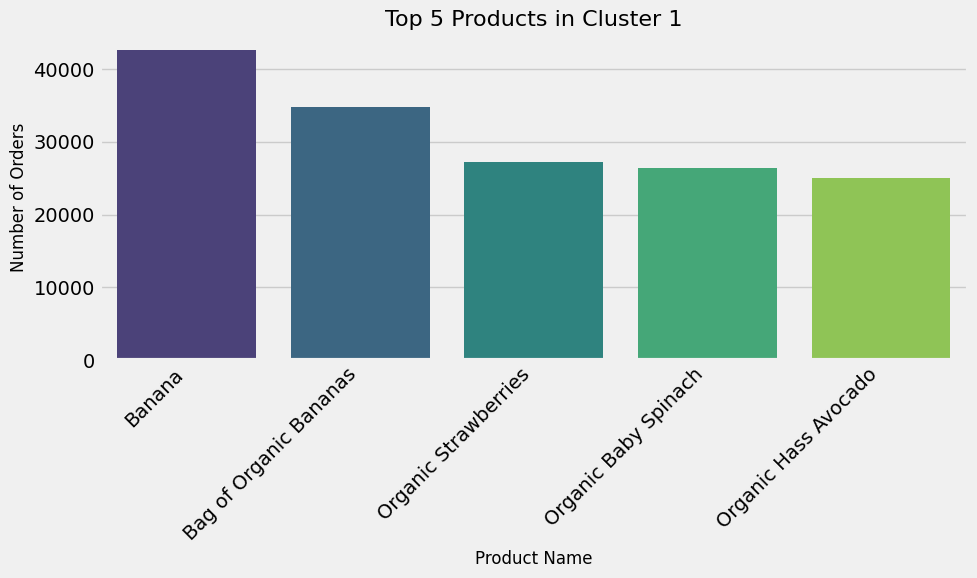

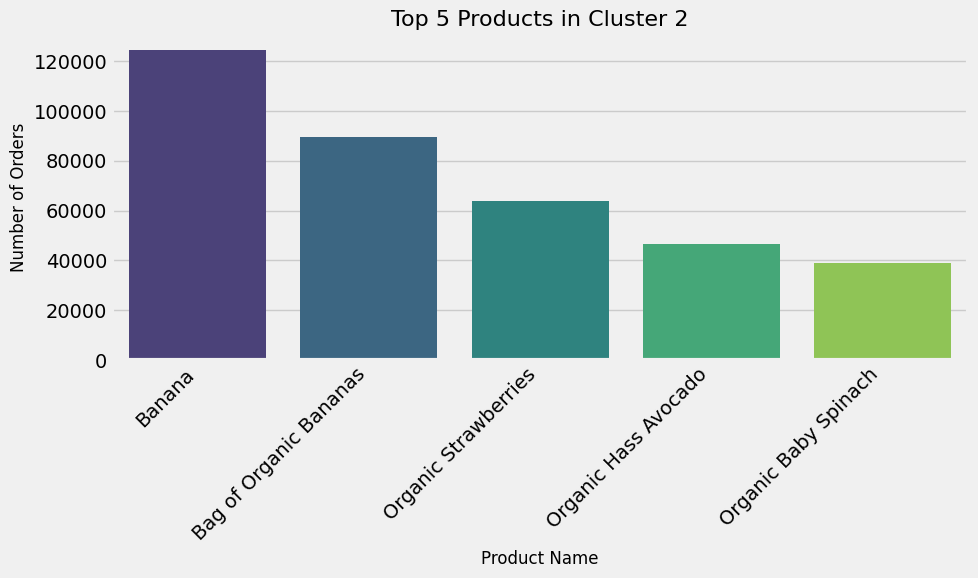

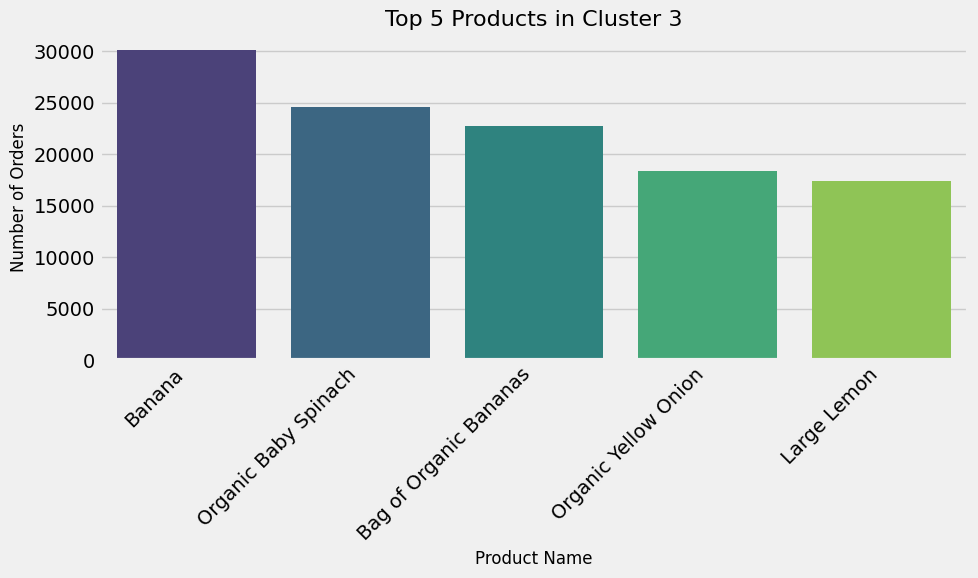

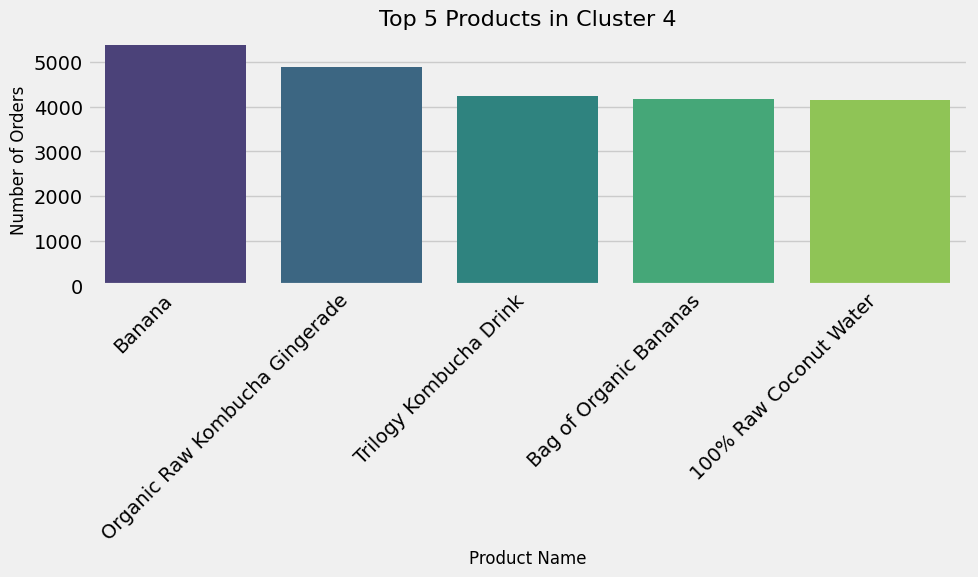

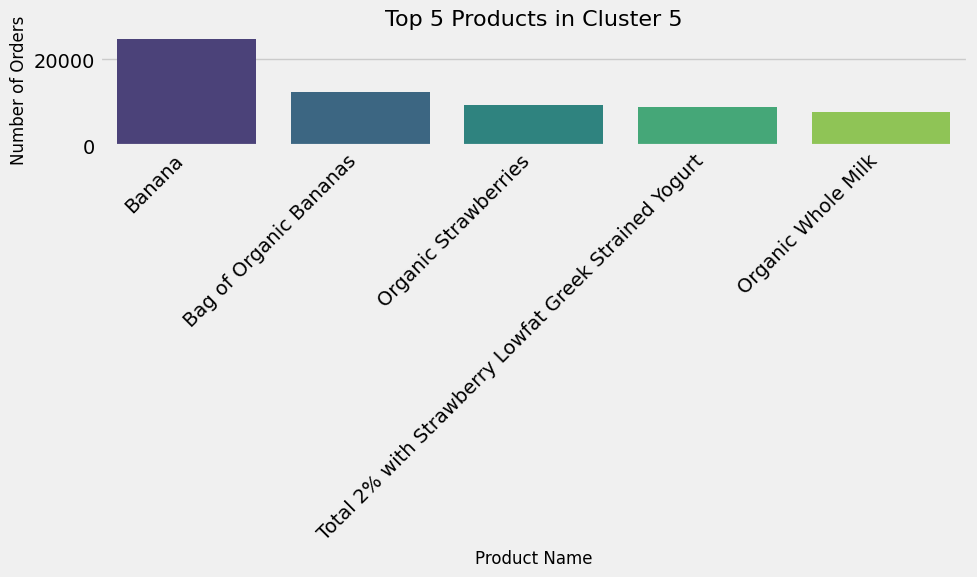

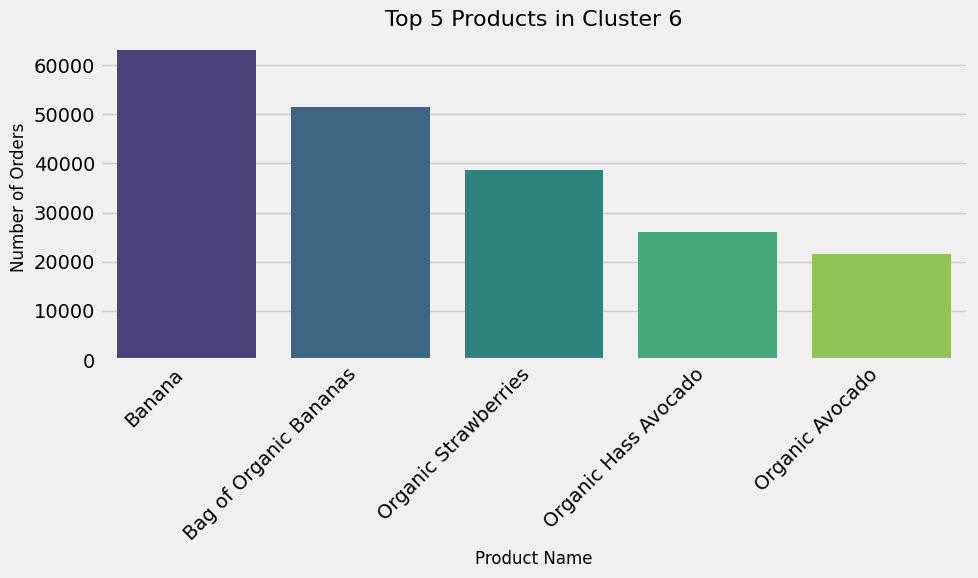

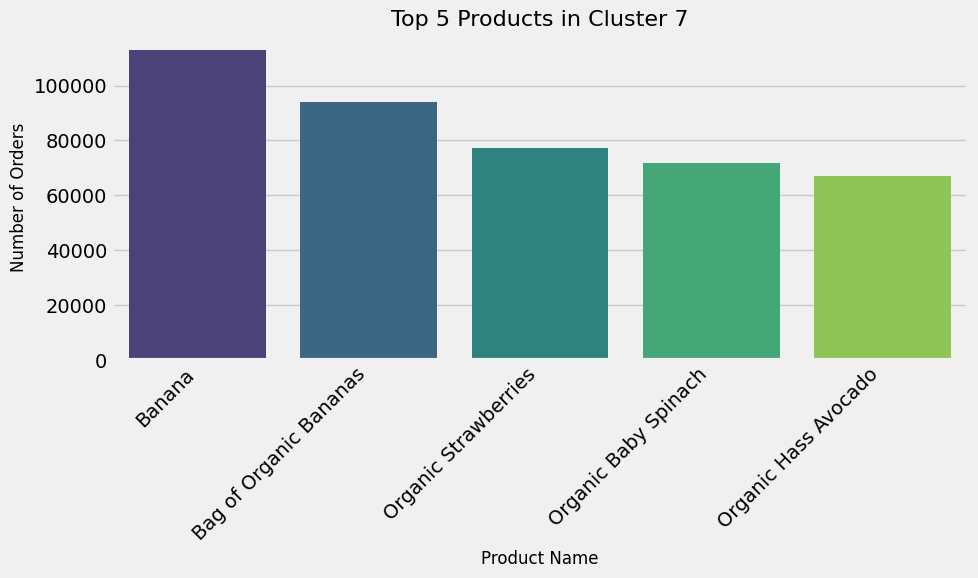

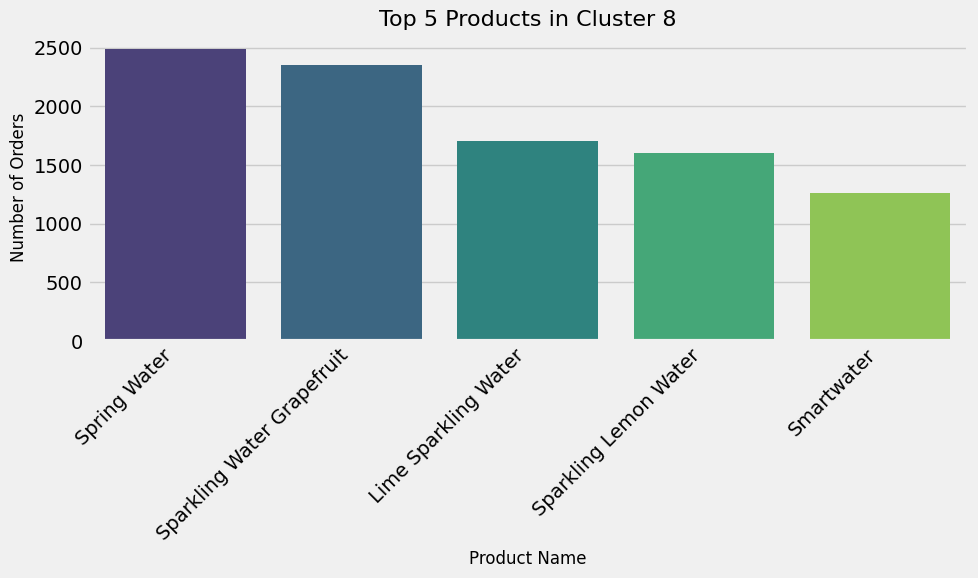

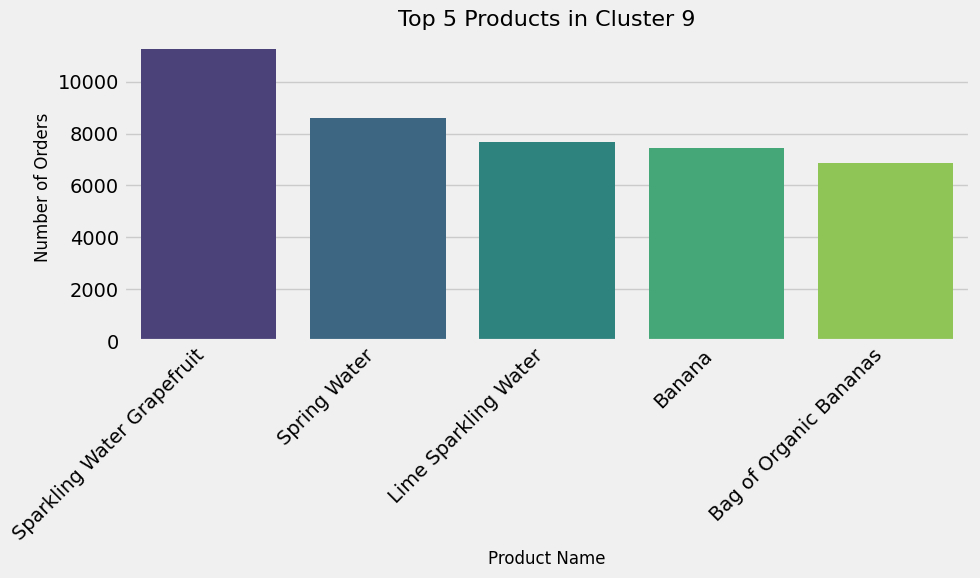

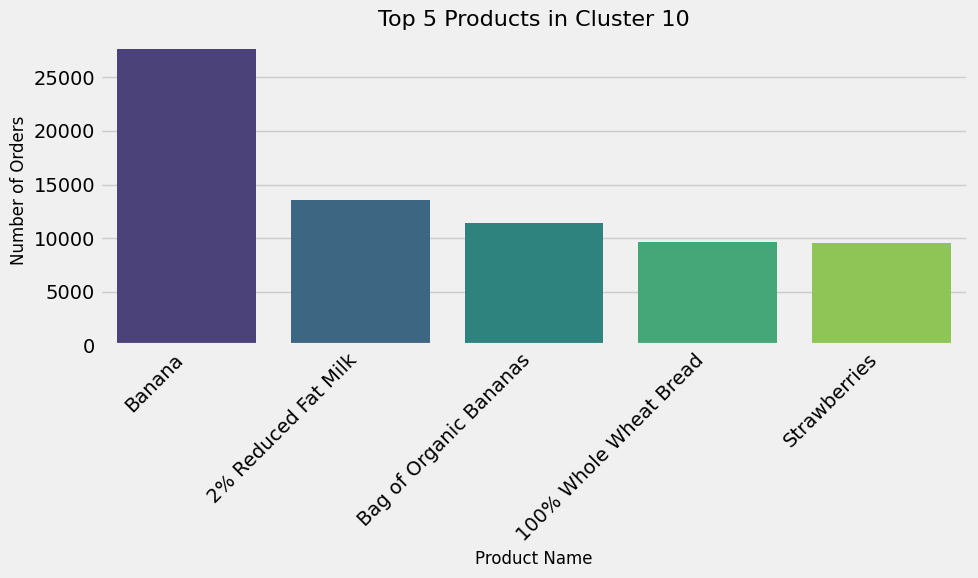

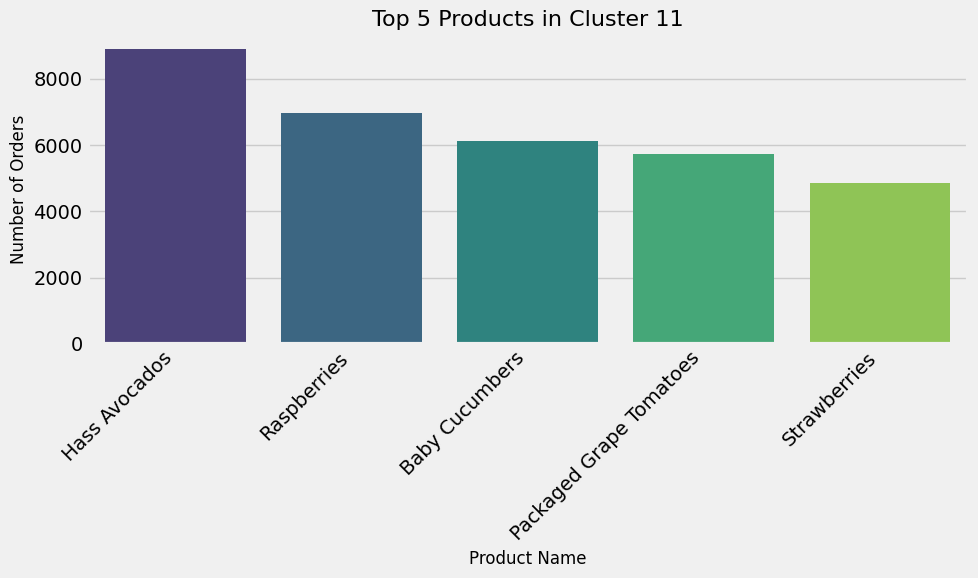

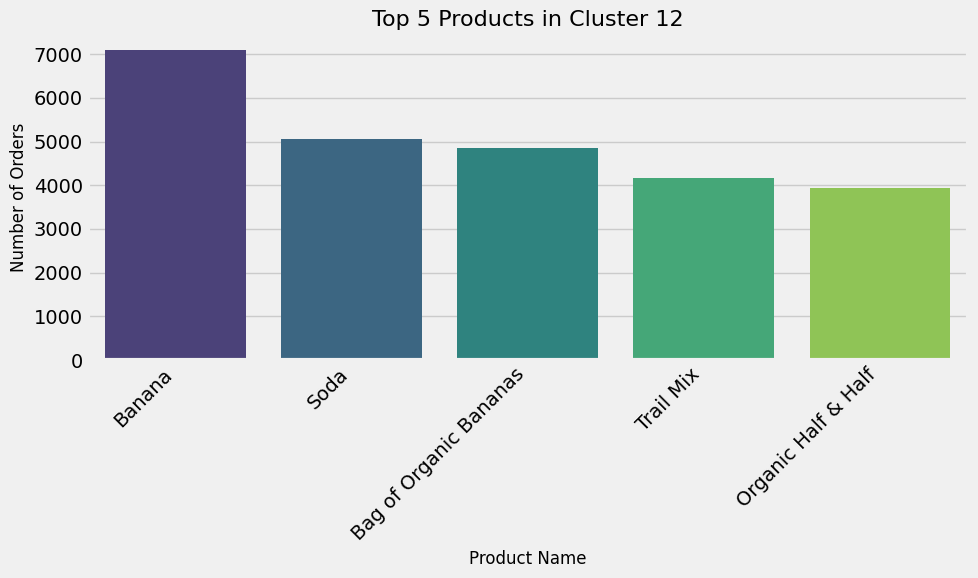

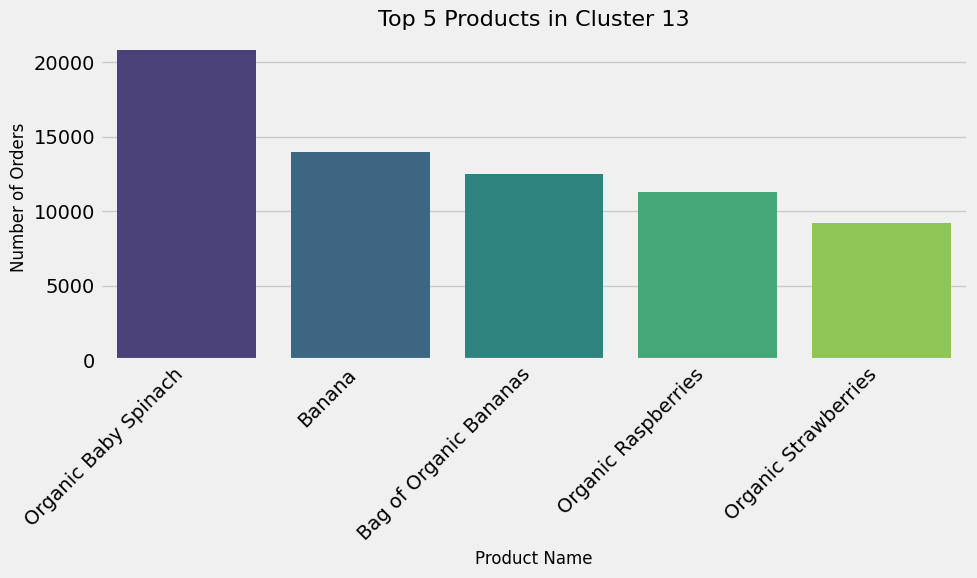

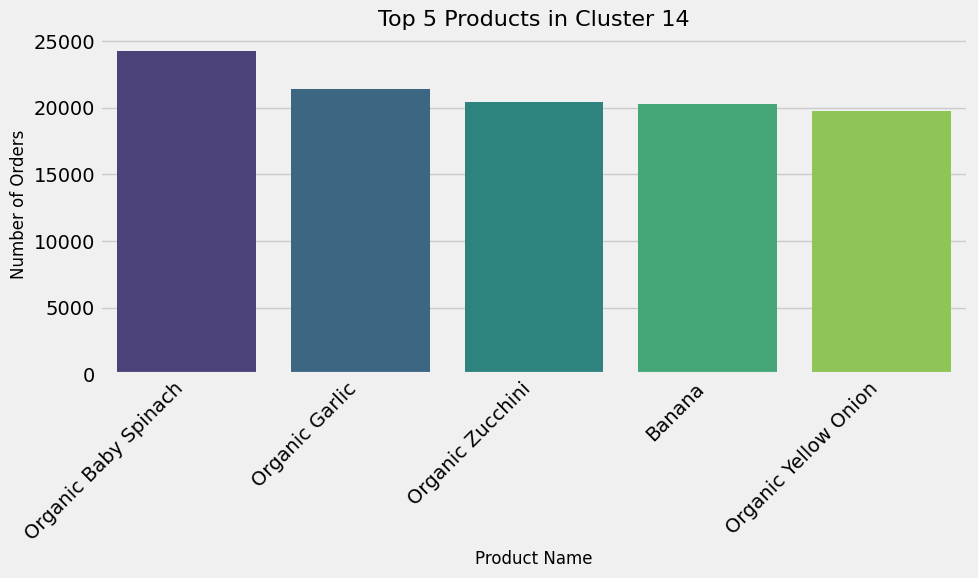

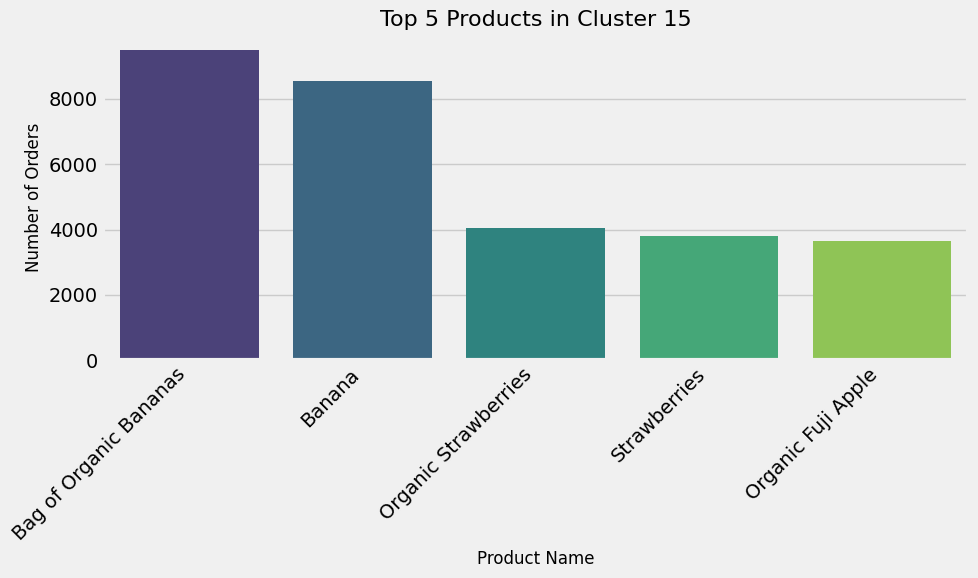

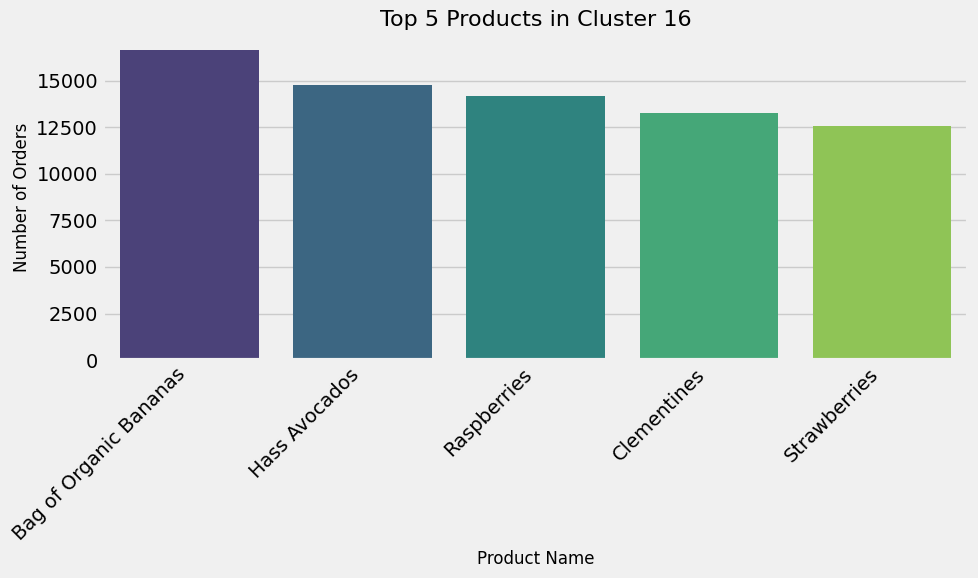

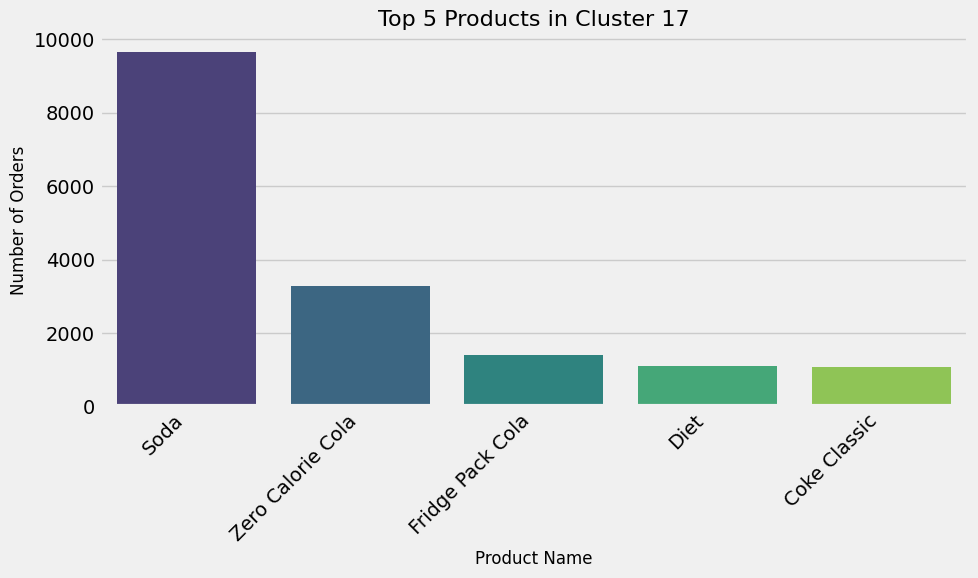

In [32]:
clusters = top_products_by_cluster['cluster'].unique()

plt.figure(figsize=(15, 8))

# Iterate through each cluster and create a bar plot for the top 5 products
for cluster in clusters:
    # Filter the data for the current cluster
    cluster_data = top_products_by_cluster[top_products_by_cluster['cluster'] == cluster]

    # Plot the top 5 products for the current cluster
    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=cluster_data['product_name'],
        y=cluster_data['product_id'],
        palette='viridis'
    )

    plt.title(f"Top 5 Products in Cluster {cluster}", fontsize=16)
    plt.xlabel('Product Name', fontsize=12)
    plt.ylabel('Number of Orders', fontsize=12)
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

In [37]:
dep_vol_per_cluster = pd.DataFrame(all_orders_cluster.groupby(['cluster',"department"]).count())[["order_id"]].unstack(level=0).divide(orders_per_cluster.values, axis=1)

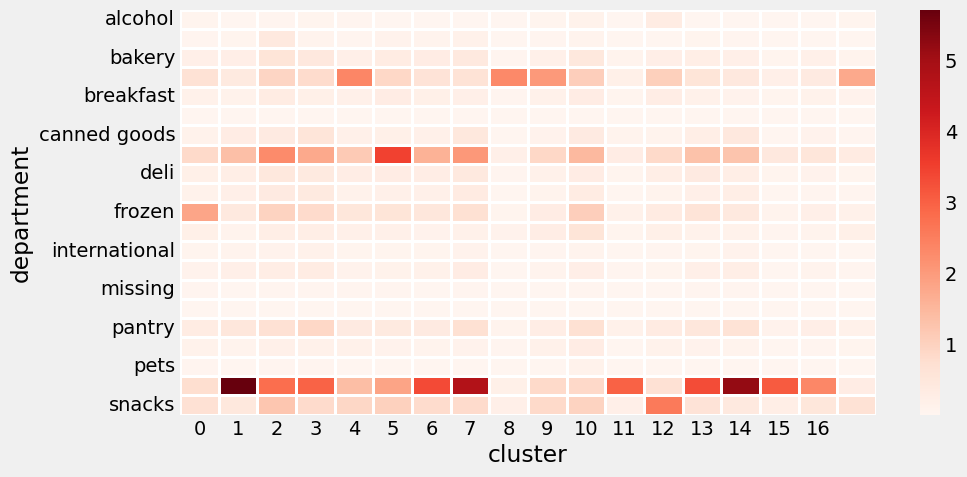

In [38]:
plt.figure(figsize=(10,5))
sns.heatmap(data=dep_vol_per_cluster, cmap="Reds", linewidths=1, xticklabels=range(0,17))
plt.xlabel("cluster")
plt.show()

In [39]:
# Calculate the total number of orders per cluster
orders_per_cluster = all_orders_cluster.groupby("cluster")["order_id"].nunique()

# Verify the number of clusters
num_clusters = len(orders_per_cluster)

# Check the length of the orders_per_cluster.values array
print("Length of orders_per_cluster.values array:", len(orders_per_cluster.values))

Length of orders_per_cluster.values array: 18


In [40]:
# Calculate the volume of orders per department per cluster
dep_vol_per_cluster = all_orders_cluster.groupby(['cluster', 'department']).size().unstack(level=0)

In [41]:
# Check if the number of clusters matches the expected length
if num_clusters == len(dep_vol_per_cluster.columns):
    # Divide the volume of orders per department by the total orders per cluster
    dep_vol_per_cluster = dep_vol_per_cluster.divide(orders_per_cluster.values, axis=1)
else:
    print("Number of clusters does not match the length of dep_vol_per_cluster.columns")

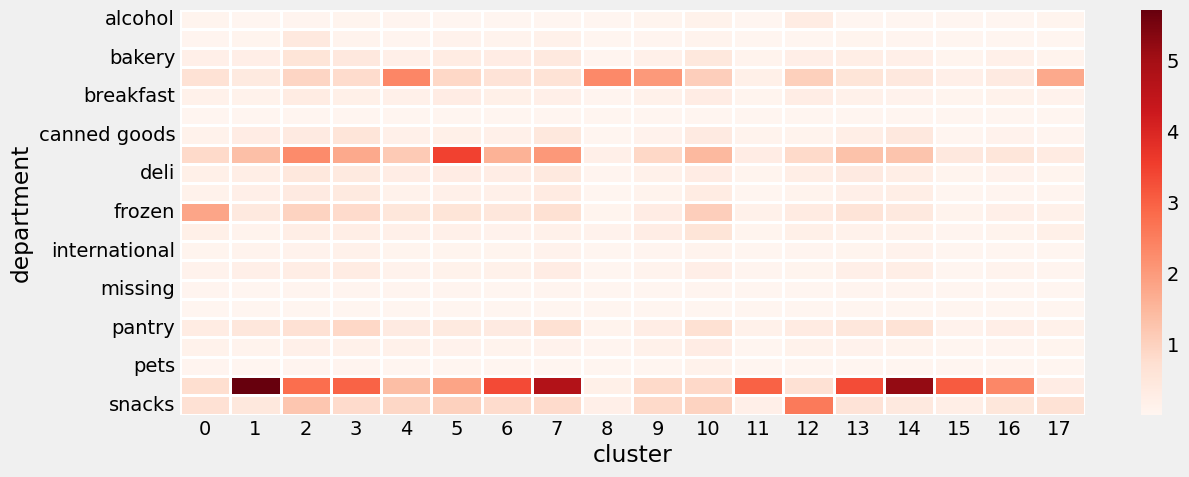

In [42]:
plt.figure(figsize=(13, 5))
sns.heatmap(data=dep_vol_per_cluster, cmap="Reds", linewidths=1, xticklabels=range(num_clusters))
plt.xlabel("cluster")
plt.show()

In [43]:
dep_pct_per_cluster = pd.DataFrame(all_orders_cluster.groupby(['cluster', 'department']).size().unstack(level=0))

In [44]:
aisle_vol_per_cluster = all_orders_cluster.groupby(["cluster", "aisle"]).count()["order_id"].unstack(level=0).divide(orders_per_cluster.values, axis=1)

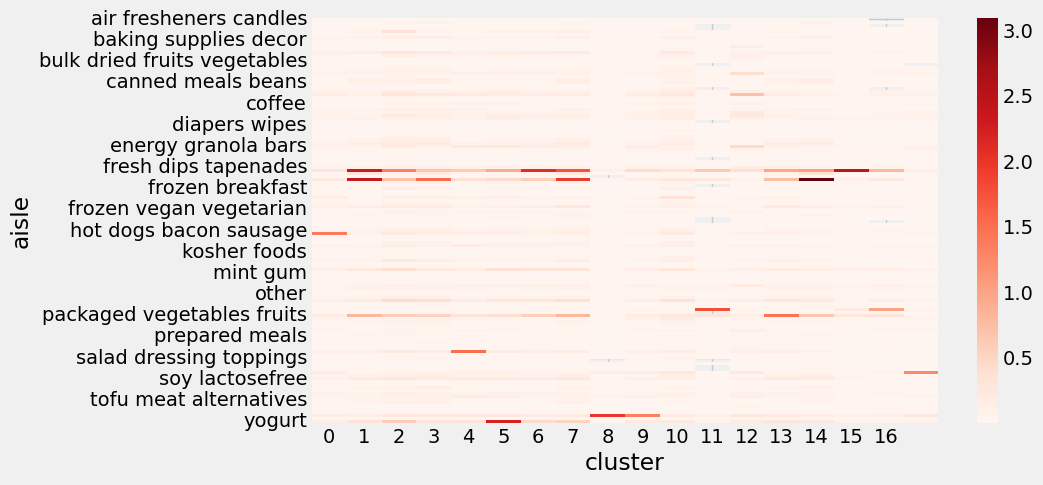

In [45]:
plt.figure(figsize=(9,5))
sns.heatmap(data=aisle_vol_per_cluster, xticklabels=range(0,17), cmap="Reds")
plt.xlabel("cluster")

plt.show()

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;"> Savings</h1>
Exporting our clustered dataframe to pyarrow (for compression) for use in collaborative filtering algorithm.

In [46]:
dummy_df = all_orders_cluster[["order_id", "product_id", "cluster", "user_id"]]

In [47]:
# Save the Parquet file in the 'Savings' folder
table = pa.Table.from_pandas(dummy_df, preserve_index=False)
parquet_file = f"Savings/dummy_k{k}.parquet"
pq.write_table(table, parquet_file)

In [48]:
# Create a ZIP file and save it in the 'Savings' folder
zip_file = f'Savings/dummy_k{k}_parq.zip'
with ZipFile(zip_file, 'w') as zipObj:
    zipObj.write(parquet_file)